# 2. CART Decision Trees

This notebook will show different examples of CART decision trees.
The dataset used for them is [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) challenge from Kaggle. It contains about 10 years of daily weather observations from many locations across Australia. 

### Index:
1. [Packages required](#1.-Packages-required)
2. [Loading data](#2.-Loading-data)
3. [Example 1](#3.-Example-1)

# 1. Packages required

In [19]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree

# 2. Loading data

In [ ]:
!pip install kaggle

In [21]:
os.environ['KAGGLE_USERNAME'] = "ginesmeca" #User name in Kaggle
os.environ['KAGGLE_KEY'] = "4fab0a819b6b377c5f6fd16dede7d525" # Kaggle/ account / create key

import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('jsphyg/weather-dataset-rattle-package', path='../data/01_raw', unzip=True)

weather = pd.read_csv('../data/01_raw/weatherAUS.csv')

# 3. Example 1

We are interested in show how is, graphically, a decision tree. We build one focus on predict 'RainTomorrow' with only two dependent variables (to graph it) and with maximum depth equals to 2. The dependent variables we will choose are: 'MinTemp' and 'Rainfall'.

In [22]:
#We select the variables we are interested in:
data_ex1 = weather[['MinTemp', 'Rainfall', 'RainTomorrow']].dropna()
data_ex1.head()

,MinTemp,Rainfall,RainTomorrow
0,13.4,0.6,No
1,7.4,0.0,No
2,12.9,0.0,No
3,9.2,0.0,No
4,17.5,1.0,No


[Text(167.4, 181.2, 'X[1] <= 0.55\ngini = 0.344\nsamples = 112255\nvalue = [87464, 24791]'),
 Text(83.7, 108.72, 'X[1] <= 0.15\ngini = 0.243\nsamples = 82072\nvalue = [70461, 11611]'),
 Text(41.85, 36.23999999999998, 'gini = 0.226\nsamples = 72131\nvalue = [62779, 9352]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.351\nsamples = 9941\nvalue = [7682, 2259]'),
 Text(251.10000000000002, 108.72, 'X[1] <= 5.95\ngini = 0.492\nsamples = 30183\nvalue = [17003, 13180]'),
 Text(209.25, 36.23999999999998, 'gini = 0.462\nsamples = 18714\nvalue = [11923, 6791]'),
 Text(292.95, 36.23999999999998, 'gini = 0.493\nsamples = 11469\nvalue = [5080, 6389]')]

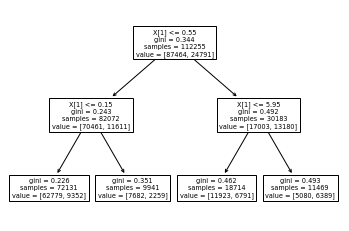

In [24]:
#We obtain our dependent and independent variables:
x_ex1 = data_ex1[['MinTemp', 'Rainfall']]
y_ex1 = data_ex1['RainTomorrow']
#We separate in train/test data:
x_train, x_test, y_train, y_test = train_test_split(x_ex1, y_ex1, test_size=0.2)

ex1 = tree.DecisionTreeClassifier(max_depth = 2)

ex1.fit(x_train, y_train)

tree.plot_tree(ex1)